In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.model_selection import KFold
import sklearn.metrics as mtr
from scipy.stats import sem

import utilcompute as uc
import preprocessing as pre
from pprint import pprint

from sklearn.datasets import load_boston

In [2]:
data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO' , 'B', 'LSTAT', 'MEDV']

print(load_boston().DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [4]:
for (f_index, f) in enumerate(features) :
    print('{0} : {1}/{2}'.format(f, len(df[f].value_counts()), len(df[f])))
    print()

CRIM : 504/506

ZN : 26/506

INDUS : 76/506

CHAS : 2/506

NOX : 81/506

RM : 446/506

AGE : 356/506

DIS : 412/506

RAD : 9/506

TAX : 66/506

PTRATIO : 46/506

B : 357/506

LSTAT : 455/506



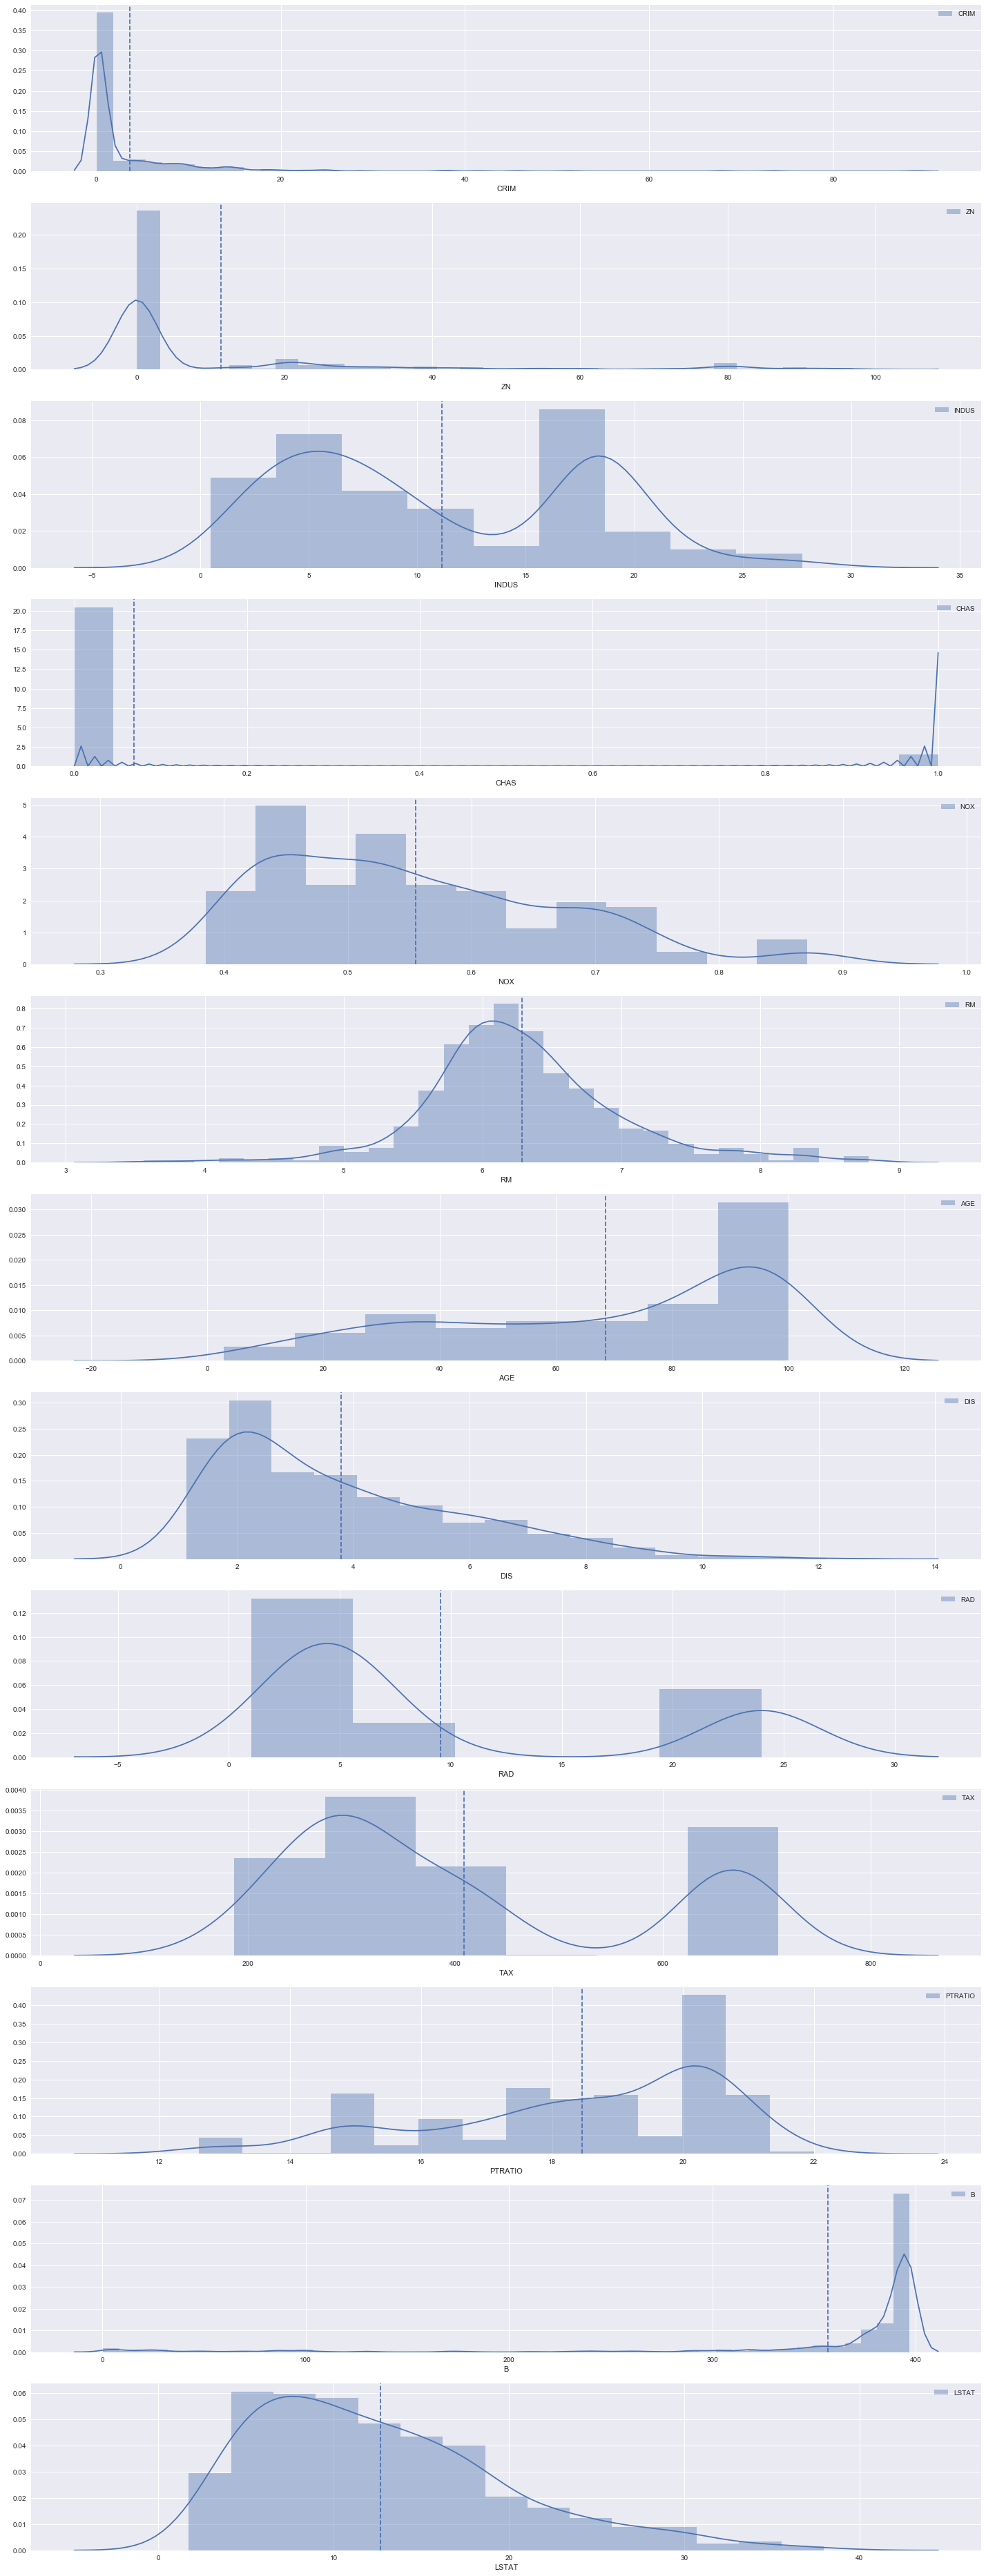

In [5]:
fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

for (f_index, f) in enumerate(features) :
    ax = axs[f_index]
    subset = df[f]        
    sns.distplot(a= subset, ax = ax, label = f)   
    ax.axvline(x = subset.mean(), linestyle='--')
    ax.legend(loc='best') 

#plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

#vif_dict = uc.compute_vif(df = df, features = [f for f in features if (f != 'BSM_2')])
#print('df : ')
#print()
#pprint(vif_dict)

print()

selected_features = [f for f in features if (f != 'CHAS')]
df_std = pre.standardize(df = df, included = selected_features, excluded = ['CHAS'] + [target])

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)



df : 

{'AGE': 21.386773583047781,
 'B': 20.066007061121244,
 'CHAS': 1.1528909172683364,
 'CRIM': 2.0746257632525675,
 'DIS': 14.699368125642422,
 'INDUS': 14.484283435031545,
 'LSTAT': 11.088865100659874,
 'NOX': 73.902211708121285,
 'PTRATIO': 85.027313520427597,
 'RAD': 15.154741587164722,
 'RM': 77.934968671814261,
 'TAX': 61.226929320337554,
 'ZN': 2.8438903527570782}

df_std : 

{'AGE': 3.1002673392586724,
 'B': 1.3455646446773111,
 'CHAS': 1.0684777345909895,
 'CRIM': 1.7729990647080087,
 'DIS': 3.9564782116784722,
 'INDUS': 3.9880590549909218,
 'LSTAT': 2.9373521677485397,
 'NOX': 4.3947004495473641,
 'PTRATIO': 1.7980519223650253,
 'RAD': 7.4741562378536273,
 'RM': 1.934023699815258,
 'TAX': 8.9986963568189147,
 'ZN': 2.298604367483295}


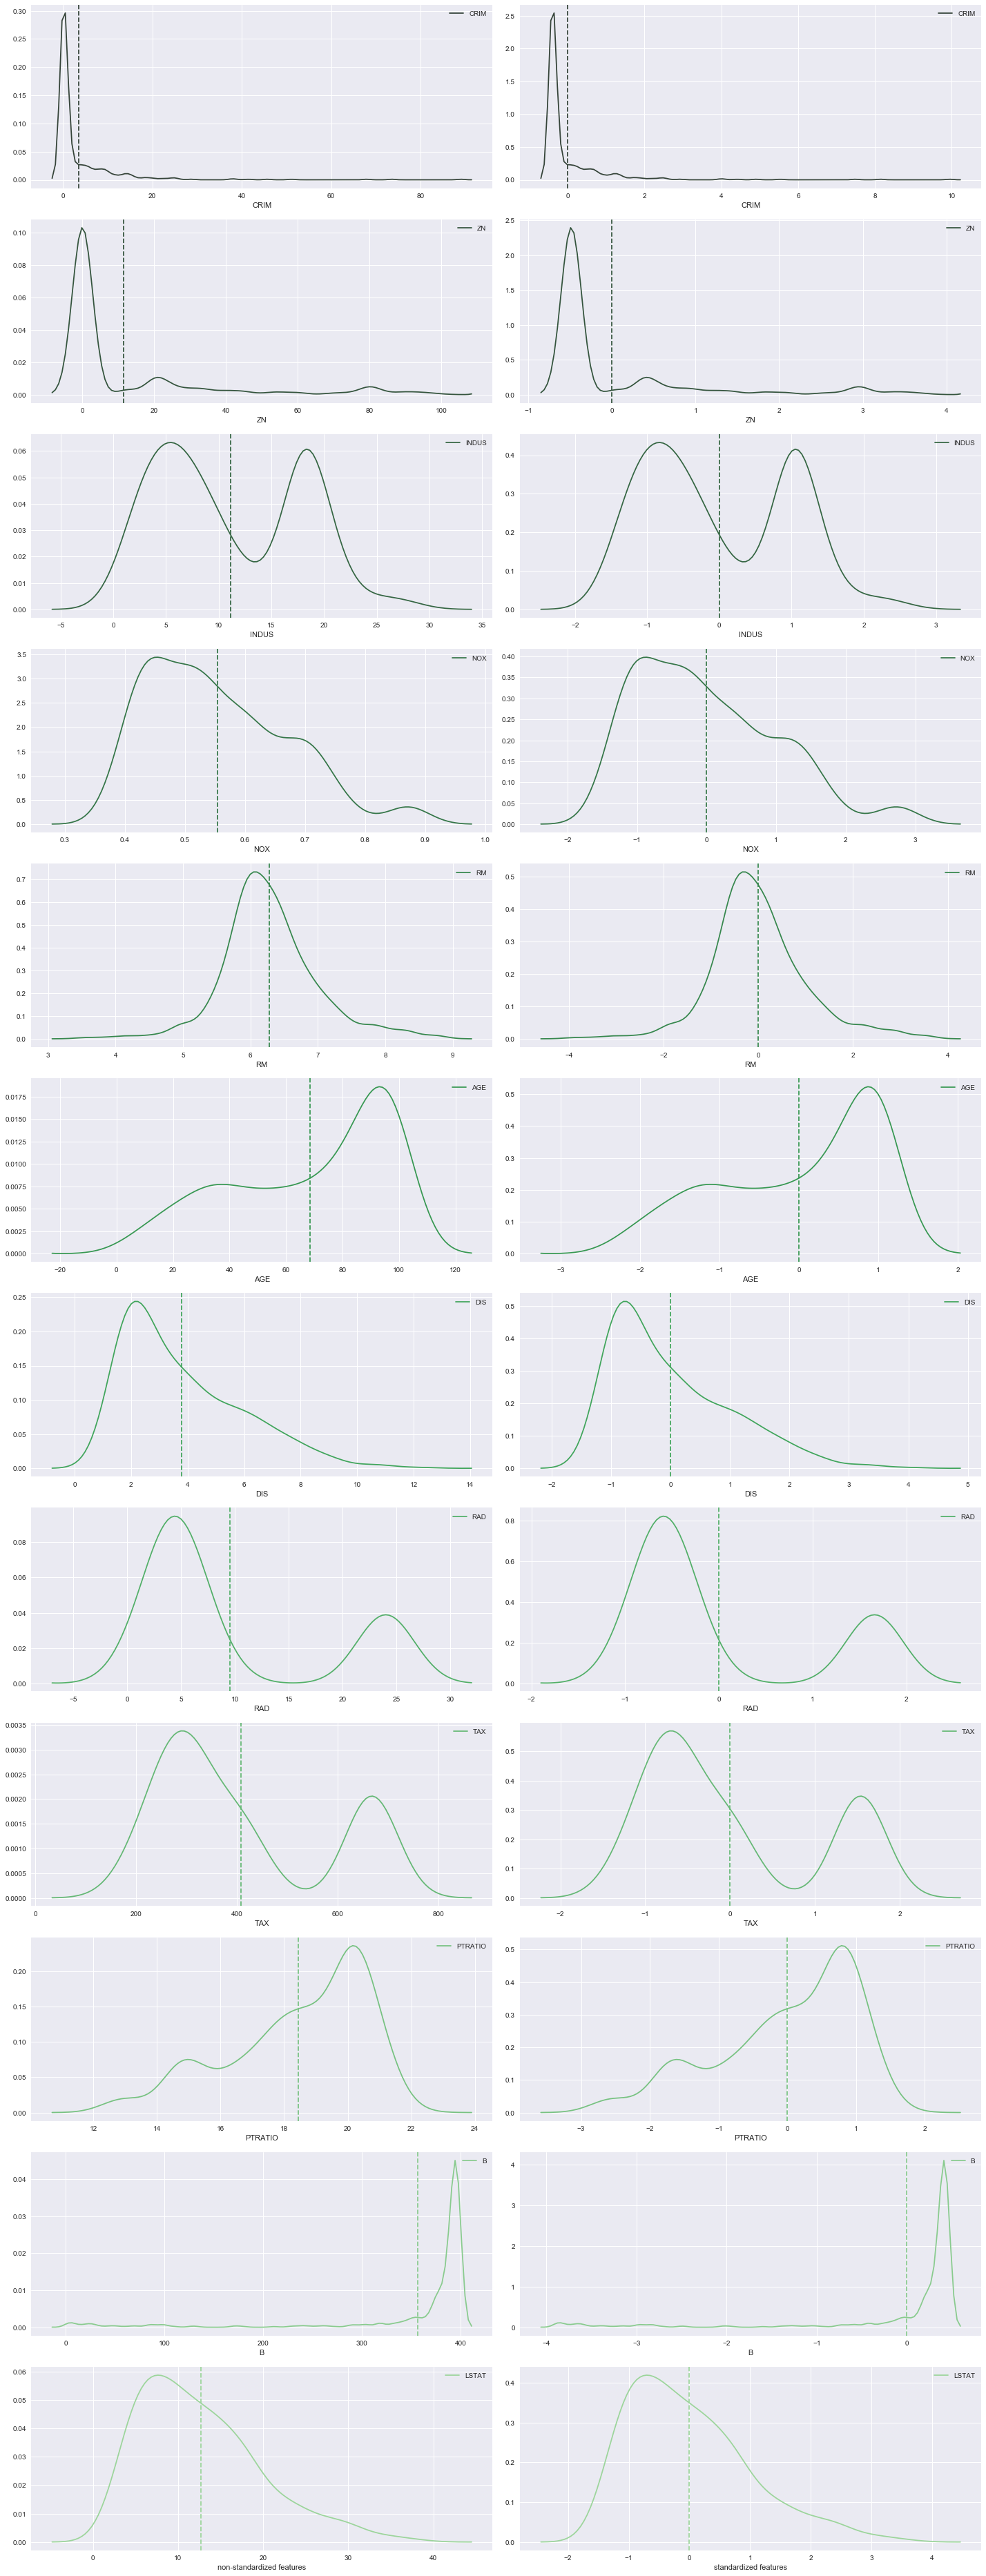

In [7]:
fig, axs = plt.subplots(nrows = len(selected_features), ncols = 2, figsize=(20, 4 * len(features)))    
pal = sns.color_palette("Greens_d", len(selected_features) )

p = 0
for (f_index,f) in enumerate(selected_features) :
    ax = axs[f_index][0] 
    subset = df[f]       
    sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)   
    ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
    p += 1
ax.set_xlabel('non-standardized features')
ax.legend(loc='best')

p = 0
for (f_index,f) in enumerate(selected_features) :
    ax = axs[f_index][1] 
    subset = df_std[f]        
    sns.distplot(a = subset, hist = False, kde = True, rug = False, color = pal[p], ax = ax, label = f)    
    ax.axvline(x = subset.mean(), color = pal[p], linestyle='--')
    p += 1
ax.set_xlabel('standardized features')
ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [8]:
def compute_kfold_stats(df, features, target, linear_model_name, linear_model_args, note):
    
    n_splits = 10
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
    
    columns = ['linear_model_name', 'note', 'iteration', 'err_train', 'err_test'] + ['intercept'] + features
    results_df = pd.DataFrame(data = None, index = None, columns = columns)


    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

        fold_train = df.iloc[train_positions]   
        fold_test = df.iloc[test_positions]  

        # if (k == 0):
        #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
        #    print('test  indices : {0} - {1}'.format(fold_test.index.values[:3], fold_test.index.values[-3:]))
        #    print()
        
        
        linear_model_class_ = getattr(lm, linear_model_name)
        if (linear_model_args):
            model = linear_model_class_(**linear_model_args)
        else:
            model = linear_model_class_()
        
        #if (k == 0):
        #    print('{0}  @   args = {1}   :   k = {2}'.format(linear_model_name, linear_model_args, k + 1 ))
        #    print('model : ', model)
        #    print()
            
        model.fit(fold_train[features], fold_train[target])

        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])

        r2_train = mtr.r2_score(y_true = fold_train[target], y_pred = y_pred_train)
        r2_test = mtr.r2_score(y_true = fold_test[target], y_pred = y_pred_test)
        
        #print('r2_train : ', r2_train)
        #print('r2_test  : ', r2_test)
        #print()

        values_dict = {
            'linear_model_name' : linear_model_name,
            'note'              : note,
            'iteration'         : k + 1,            
            'err_train'         : 1 - r2_train,
            'err_test'          : 1 - r2_test,
            'intercept'         : model.intercept_, 
        }

        for f in range(len(features)):
            values_dict[features[f]] = model.coef_[f]
        
        #if (k == 0):
        #    print('iteration : k = {0}'.format(k+1))
        #    print('intercept : {0}'.format(model.intercept_))
        #    print('coef      : {0}'.format(model.coef_))
        #    print()

        results_index = k
        results_df.loc[results_index] = values_dict     

    #results_df = results_df.astype(dtype = 'float')
    
    return results_df


In [9]:
results = compute_kfold_stats(
    df = df, 
    features = features, 
    target = target, 
    linear_model_name = 'LinearRegression', 
    linear_model_args = {'fit_intercept' : True},
    note = None
)

print(results['err_test'])

0    0.266651
1    0.527702
2    2.010977
3    0.358737
4    0.452902
5    0.263898
6    0.622382
7    1.130269
8    1.783723
9    0.581382
Name: err_test, dtype: float64


In [13]:
results_temp = compute_kfold_stats(
    df = df_std, 
    features = features, 
    target = target, 
    linear_model_name = 'Ridge', 
    linear_model_args = {'alpha' : .1, 'fit_intercept' :True},
    note = None
)

results = results.append(results_temp).reset_index(drop = True)

print(results_temp['err_test'])

0    0.266399
1    0.527270
2    2.006817
3    0.358799
4    0.451984
5    0.263787
6    0.621664
7    1.129904
8    1.783476
9    0.580456
Name: err_test, dtype: float64


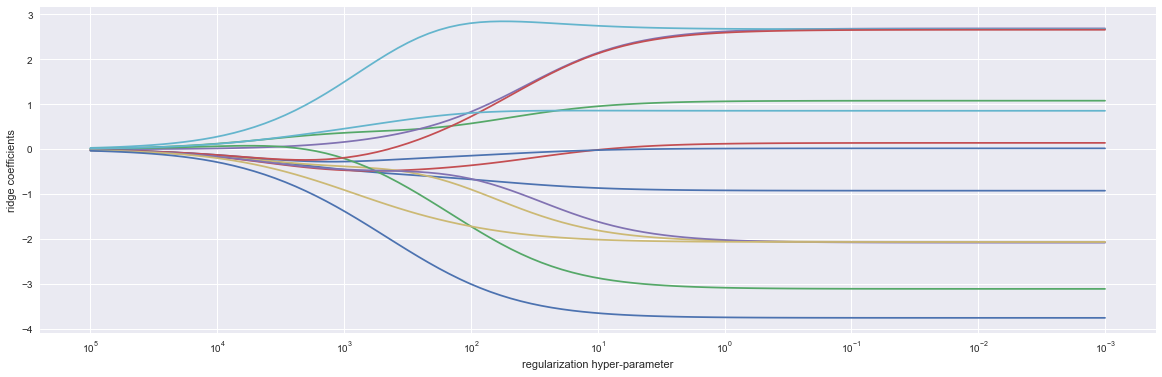

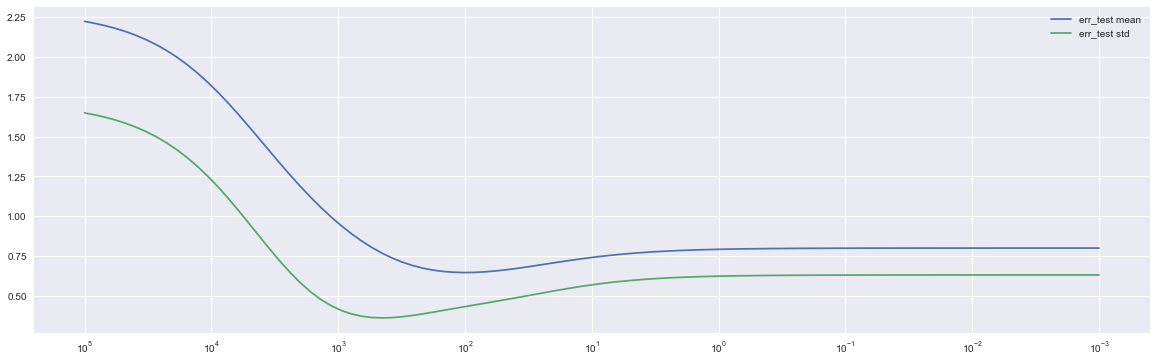

In [16]:
n_alphas = 100
alphas = np.logspace(-3, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = lm.Ridge(alpha = a, fit_intercept = True)
    ridge.fit(df_std[features], df_std[target])    
    coefs.append(ridge.coef_)
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))    

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('regularization hyper-parameter')
plt.ylabel('ridge coefficients')

plt.show()



err_test_mean = []
err_test_std = []

for a in alphas:
    results_temp = compute_kfold_stats(
        df = df_std, 
        features = features, 
        target = target, 
        linear_model_name = 'Ridge', 
        linear_model_args = {'alpha' : a, 'fit_intercept' : True},
        note = a
    )
    
    #for (f_index, f) in enumerate(['AGE', 'BMI']):
    #    coefs.append(results_temp[f].mean())
    
    err_test_mean.append(results_temp['err_test'].mean())
    err_test_std.append(results_temp['err_test'].std())
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 6))    

ax.plot(alphas, err_test_mean, label = 'err_test mean')
ax.plot(alphas, err_test_std, label = 'err_test std')
ax.legend(loc='best') 
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis

plt.show()